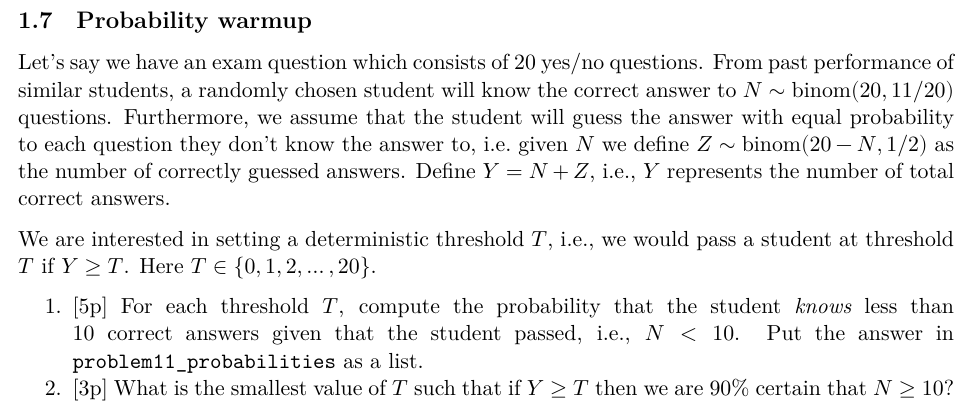

# Part 1: Compute Probabilities

We need to compute $P(N < 10 \mid Y \geq T)$, where:

- $N \sim \text{Binom}(20, 11/20)$,
- $Z \sim \text{Binom}(20, 1/2)$,
- $Y = N + Z$.

### Steps:

1. **Probability Distribution of $N$:**
   - Use the PMF:
     $$
     P(N = k) = \binom{20}{k} \left(\frac{11}{20}\right)^k \left(\frac{9}{20}\right)^{20-k}.
     $$

2. **Distribution of $Y$:**
   - $Y$ is the sum of two binomial random variables:
     - $N \sim \text{Binom}(20, 11/20)$,
     - $Z \sim \text{Binom}(20, 1/2)$.
   - The PMF of $Y$ can be computed by convolution of the two distributions.

3. **Conditioned on $Y \geq T$:**
   - Compute:
     $$
     P(N < 10 \mid Y \geq T) = \frac{\sum_{Y \geq T} P(N < 10, Y)}{\sum_{Y \geq T} P(Y)}.
     $$


# Part 2: Threshold $T$

Find the smallest $T$ such that:
$$
P(N \geq 10 \mid Y \geq T) \geq 0.9,
$$
or equivalently:
$$
P(N < 10 \mid Y \geq T) \leq 0.1.
$$


In [7]:
import numpy as np
from scipy.stats import binom

# Constants
p = 11 / 20  # Success probability for N
n = 20       # Number of trials for both N and Z

# PMF of N and Z
p_N = lambda k: binom.pmf(k, n, p)
p_Z = lambda k: binom.pmf(k, n, 0.5)

# Compute the joint distribution of Y = N + Z
p_Y = np.zeros(41)  # Y ranges from 0 to 40
for n_val in range(21):  # N ranges from 0 to 20
    for z_val in range(21):  # Z ranges from 0 to 20
        p_Y[n_val + z_val] += p_N(n_val) * p_Z(z_val)

# Compute P(N < 10 | Y >= T) for each T
problem11_probabilities = []
for T in range(21):
    # Numerator: P(N < 10 and Y >= T)
    numerator = 0
    denominator = 0
    for y in range(T, 41):
        for n_val in range(10):  # N < 10
            if n_val <= y:  # Only valid if N <= Y
                numerator += p_N(n_val) * p_Z(y - n_val)
        denominator += p_Y[y]
    problem11_probabilities.append(numerator / denominator if denominator > 0 else 0)

# Find the smallest T for Part 2
problem12_T = next((T for T, prob in enumerate(problem11_probabilities) if prob <= 0.1), 20)

# Results
print("Probabilities for each T:", problem11_probabilities)
print("Smallest T such that P(N < 10 | Y >= T) <= 0.1:", problem12_T)

# Output for the solution template
problem11_probabilities = problem11_probabilities
problem12_T = problem12_T


Probabilities for each T: [0.24928935982841163, 0.24928935982832864, 0.2492893598246394, 0.2492893597447257, 0.2492893586205915, 0.24928934707588196, 0.2492892548129875, 0.24928865757958774, 0.2492854393632485, 0.249270715363086, 0.24921266034663642, 0.24901323885976248, 0.2484125907221324, 0.24682342575359875, 0.2431365236651159, 0.23565863249235838, 0.22242563811713598, 0.2019840649543555, 0.17433212410274765, 0.14141105875978702, 0.10672491537890562]
Smallest T such that P(N < 10 | Y >= T) <= 0.1: 20


### Steps:

1. **Input Parameters:**
   - `generator`: A function that provides pseudo-random numbers (e.g., the LCG implemented in Part 1).
   - `period`: The period of the generator (typically the modulus $M$ of the LCG).
   - `size`: The number of samples to generate.
   - `seed`: The starting point for the generator.

2. **Logic:**
   - Use the provided generator to produce pseudo-random numbers.
   - Normalize the generator's output to fit within the range $[0, 1]$.

3. **Output:**
   - A list of pseudo-random numbers uniformly distributed in $[0, 1]$.


In [8]:
def problem2_uniform(generator=None, period=1, size=None, seed=0):
    """
    Takes a generator and produces samples from the uniform [0, 1] distribution
    according to size.

    Parameters
    ----------
    generator : a function of type generator(size, seed) and produces the same
                result as problem2_LCG, i.e., pseudo random numbers in the range [0, 1,..., period-1]
    period : the period of the generator
    seed : the seed to be used in the generator provided
    size : an integer denoting how many samples should be produced

    Returns
    -------
    out : a list of the uniform pseudo random numbers
    """
    if generator is None:
        raise ValueError("A generator function must be provided.")
    
    # Generate raw numbers using the provided generator
    raw_numbers = generator(size=size, seed=seed)
    
    # Normalize numbers to the [0, 1] range
    uniform_numbers = [x / period for x in raw_numbers]
    
    return uniform_numbers


# Overview of Accept-Reject Sampling

We aim to sample from the target distribution:

$$[
p_0(x) = \frac{\pi}{2} \lvert \sin(2\pi x) \rvert, \quad x \in [0, 1].
$$]

### Steps:

1. Use the uniform distribution $U[0, 1]$ as the proposal distribution.

2. Compute the acceptance probability:

   Accept $x$ if $u \leq \frac{p_0(x)}{M \cdot q(x)}$, 

   where:
   - $u \sim U[0, 1]$,
   - $q(x) = 1$ (the uniform proposal distribution),
   - $M = \pi / 2$ (the maximum value of $p_0(x)$).

3. Repeat until the desired number of samples is generated.


In [9]:
import numpy as np

def problem2_accept_reject(uniformGenerator=None, size=None, seed=0):
    """
    Takes a generator that produces uniform pseudo random [0,1] numbers
    and produces samples from (pi/2)*abs(sin(x*2*pi)) using an Accept-Reject 
    sampler with the uniform distribution as the proposal distribution.

    Parameters
    ----------
    uniformGenerator : a function of the type generator(size, seed) that produces
                       uniform pseudo random numbers from [0, 1]
    seed : the seed to be used in the generator provided
    size : an integer denoting how many samples should be produced

    Returns
    -------
    out : a list of the pseudo random numbers with the specified distribution
    """
    if uniformGenerator is None:
        raise ValueError("A uniform generator function must be provided.")
    
    # Maximum value of the target distribution
    M = np.pi / 2

    # Storage for the accepted samples
    samples = []
    np.random.seed(seed)

    while len(samples) < size:
        # Generate x and u from the uniform distribution
        x = uniformGenerator(size=1, seed=seed)[0]  # Proposal x
        u = np.random.uniform(0, 1)  # Uniform u for acceptance check
        
        # Calculate p0(x) = (pi/2) * abs(sin(2*pi*x))
        p0_x = M * abs(np.sin(2 * np.pi * x))
        
        # Accept or reject the sample
        if u <= p0_x / M:
            samples.append(x)
    
    return samples


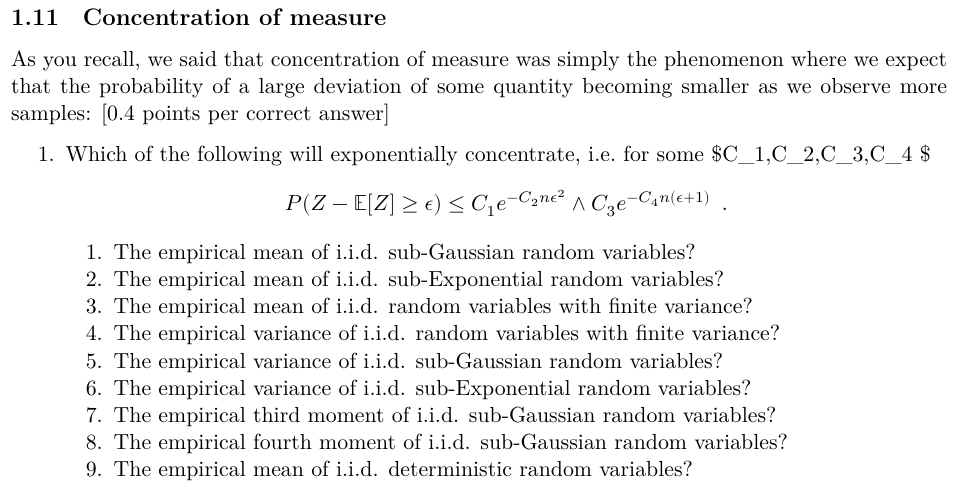
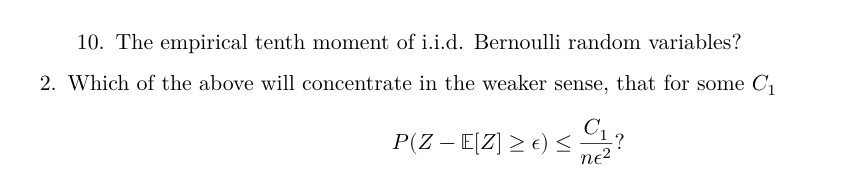

1. **Empirical mean of i.i.d. sub-Gaussian**  
   **Yes** — the usual Hoeffding/Bernstein bounds give exponential tails.

2. **Empirical mean of i.i.d. sub-Exponential**  
   **Yes** — it also satisfies a two-regime Bernstein-type bound that is still “exponential in $n$.”

3. **Empirical mean (finite variance only)**  
   **No** — that’s just Chebyshev / Central Limit Theorem; yields polynomial tails.

4. **Empirical variance (finite variance only)**  
   **No** — again, you only get polynomial concentration without further tail assumptions (you need at least a finite 4th moment to push this up, but even that is typically not fully “exponential” unless the data themselves are light-tailed).

5. **Empirical variance of i.i.d. sub-Gaussian**  
   **Yes** — sub-Gaussian $X$ implies $X^2$ is sub-Exponential, so the sample variance *does* get exponential concentration.

6. **Empirical variance of i.i.d. sub-Exponential**  
   **Yes** — with appropriate Bernstein-type arguments, still exponential in $n$.

7. **Empirical 3rd moment of i.i.d. sub-Gaussian**  
   **Yes** — because $X^3$ is typically sub-Exponential if $X$ is sub-Gaussian, so averages concentrate exponentially.

8. **Empirical 4th moment of i.i.d. sub-Gaussian**  
   **Yes** — same reasoning as #7; also yes.

9. **Empirical mean of i.i.d. deterministic**  
   **Trivially yes** — probability of deviation is $0$.

10. **Empirical 10th moment of i.i.d. Bernoulli**  
    **Yes** — Bernoulli is bounded (and hence sub-Gaussian). Note that $X^{10} = X$ for Bernoulli($p \in [0,1]$), so again you get an exponential-type tail bound.


In [10]:
# Part (1): Which concentrate exponentially (via AND)?
problem3_answer_1 = [1, 2, 5, 6, 7, 8, 9, 10]


In [11]:
# Part (2): Which concentrate at least in the weaker 1/(n e^2) sense?
problem3_answer_2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


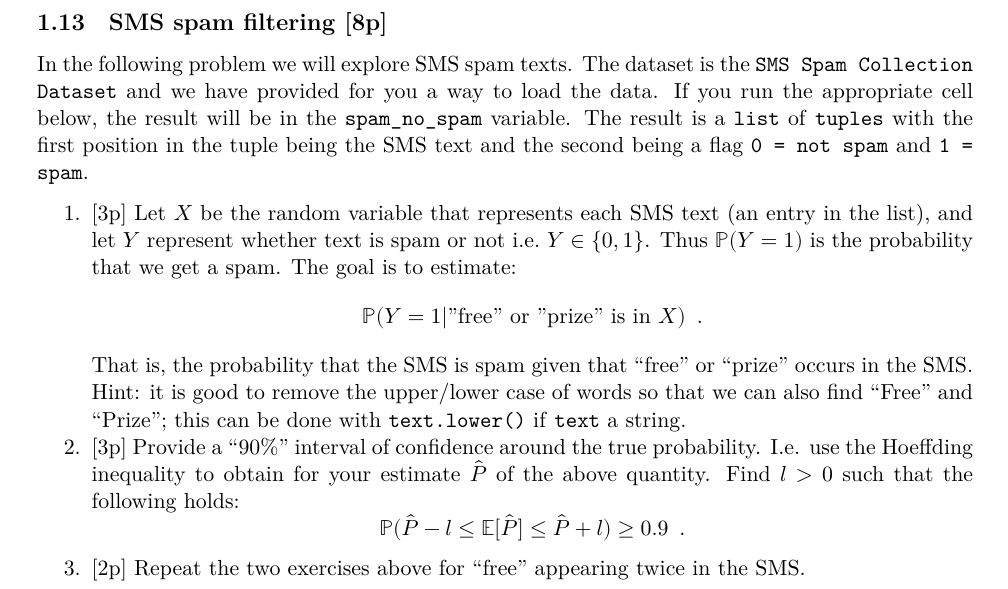

In [12]:
# Run this cell to get the SMS text data
from exam_extras import load_sms
spam_no_spam = load_sms()

ModuleNotFoundError: No module named 'exam_extras'

In [ ]:
# Filter the dataset for messages containing "free" or "prize"
filtered_messages = [entry for entry in spam_no_spam if "free" in entry[0].lower() or "prize" in entry[0].lower()]

# Count total filtered messages
n_filtered = len(filtered_messages)

# Count how many of the filtered messages are spam
n_spam_filtered = sum([entry[1] for entry in filtered_messages])

# Estimate P_hat
problem4_hatP = n_spam_filtered / n_filtered


In [ ]:
import math

# Total number of filtered messages (n_filtered)
n = n_filtered

# Compute l
problem4_l = math.sqrt((math.log(2) - math.log(0.1)) / (2 * n))


In [ ]:
# Filter for messages with "free" appearing at least twice
filtered_double_free = [entry for entry in spam_no_spam if entry[0].lower().count("free") >= 2]

# Count total filtered messages
n_double_free = len(filtered_double_free)

# Count how many of the filtered messages are spam
n_spam_double_free = sum([entry[1] for entry in filtered_double_free])

# Estimate P_hat for double "free"
problem4_hatP2 = n_spam_double_free / n_double_free

In [ ]:
# Total number of filtered messages for double "free" (n_double_free)
n2 = n_double_free

# Compute l for double "free"
problem4_l2 = math.sqrt((math.log(2) - math.log(0.1)) / (2 * n2))

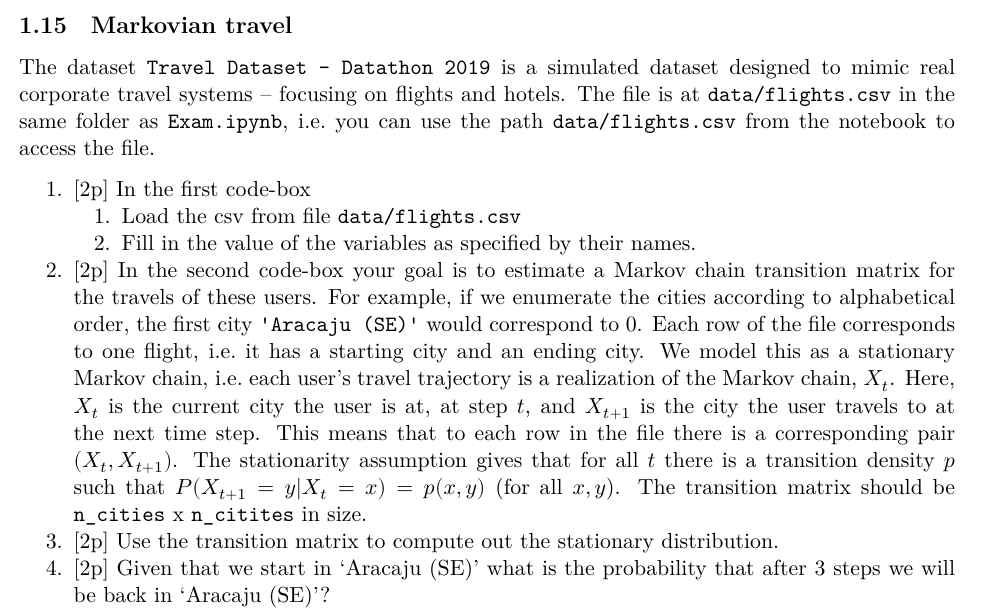

In [15]:
import pandas as pd

# Load the dataset
data = pd.read_csv('data\\flights.csv')

# Number of unique cities and users
number_of_cities = data['from'].nunique()  # Unique starting cities
number_of_userCodes = data['userCode'].nunique()  # Unique users
number_of_observations = len(data)  # Total rows in the dataset

print(f"Number of cities: {number_of_cities}")
print(f"Number of user codes: {number_of_userCodes}")
print(f"Number of observations: {number_of_observations}")


Number of cities: 9
Number of user codes: 1335
Number of observations: 271888


In [16]:
def makeFreqDict(myDataList):
 '''Make a frequency mapping out of a list of data.
 Param myDataList, a list of data.
 Return a dictionary mapping each unique data value to its frequency count.
 '''
 freqDict = {} # start with an empty dictionary
 for res in myDataList:
    if res in freqDict: # the data value already exists as a key
        freqDict[res] = freqDict[res] + 1 # add 1 to the count using␣sage integers
    else: # the data value does not exist as a key value
        freqDict[res] = 1 # add a new key-value pair for this new data␣↪value, frequency 1

 return freqDict # return the dictionary created

In [18]:
# Step 1: Load the dataset and extract relevant information
import pandas as pd
import numpy as np

# Read the CSV file (assuming it's in the same folder as the notebook)
data = pd.read_csv('data\\flights.csv')

# Extract the 'from' and 'to' cities
cities = list(data['from']) + list(data['to'])

# Step 2: Find unique cities and their counts
unique_cities = sorted(set(cities))  # The unique cities
n_cities = len(unique_cities)  # The number of unique cities

# Create mappings for cities to indices
indexToCity = {i: city for i, city in enumerate(unique_cities)}
cityToIndex = {city: i for i, city in enumerate(unique_cities)}

# Step 3: Count transitions
transitions = list(zip(data['from'], data['to']))  # List of city pairs
transition_counts = makeFreqDict(transitions)  # Use the provided function

# Step 4: Build the transition matrix
transition_matrix = np.zeros((n_cities, n_cities))  # Initialize the matrix

for (city_from, city_to), count in transition_counts.items():
    from_index = cityToIndex[city_from]
    to_index = cityToIndex[city_to]
    transition_matrix[from_index, to_index] = count

# Step 5: Normalize the transition matrix
row_sums = transition_matrix.sum(axis=1, keepdims=True)
transition_matrix = np.divide(
    transition_matrix, row_sums, out=np.zeros_like(transition_matrix), where=row_sums != 0
)

# Display results
print("Unique cities:", unique_cities)
print("Transition matrix:")
print(transition_matrix)


Unique cities: ['Aracaju (SE)', 'Brasilia (DF)', 'Campo Grande (MS)', 'Florianopolis (SC)', 'Natal (RN)', 'Recife (PE)', 'Rio de Janeiro (RJ)', 'Salvador (BH)', 'Sao Paulo (SP)']
Transition matrix:
[[0.         0.12983559 0.14487965 0.23218891 0.1057651  0.13120567
  0.07570385 0.07839029 0.10203095]
 [0.15702265 0.         0.14675591 0.25273726 0.09704669 0.12417557
  0.06478443 0.06527178 0.09220572]
 [0.15520318 0.12999309 0.         0.23751007 0.1019627  0.12979164
  0.0695004  0.07252216 0.10351675]
 [0.15079296 0.1357189  0.14398869 0.         0.11705079 0.13275294
  0.10131375 0.10119162 0.11719036]
 [0.16544797 0.1255253  0.14889057 0.28193814 0.         0.12161708
  0.03992268 0.0389141  0.07774416]
 [0.16023622 0.1253937  0.14796588 0.24963911 0.09494751 0.
  0.06223753 0.06404199 0.09553806]
 [0.16758846 0.1185846  0.14362177 0.34534642 0.05649718 0.11281594
  0.         0.         0.05554564]
 [0.17060337 0.1174579  0.14733396 0.33910196 0.05413938 0.11412535
  0.         0

In [19]:
# Step 1: Compute the stationary distribution
eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)  # Transpose to find left eigenvectors
stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]  # Eigenvector for eigenvalue 1
stationary_distribution_problem5 = stationary_vector[:, 0].real  # Extract real part
stationary_distribution_problem5 = stationary_distribution_problem5 / stationary_distribution_problem5.sum()  # Normalize

# Output
print("Stationary Distribution:")
print(stationary_distribution_problem5)


Stationary Distribution:
[0.13690932 0.1132047  0.12780262 0.21081107 0.08752133 0.11210498
 0.06184532 0.06290826 0.0868924 ]


In [20]:
# Step 1: Find the index of 'Aracaju (SE)'
start_city = 'Aracaju (SE)'
start_index = cityToIndex[start_city]

# Step 2: Compute the transition matrix raised to the power of 3
transition_matrix_3 = np.linalg.matrix_power(transition_matrix, 3)

# Step 3: Get the return probability
return_probability_problem5 = transition_matrix_3[start_index, start_index]

# Output
print(f"Return probability to {start_city} after 3 steps: {return_probability_problem5}")


Return probability to Aracaju (SE) after 3 steps: 0.13331717737273133


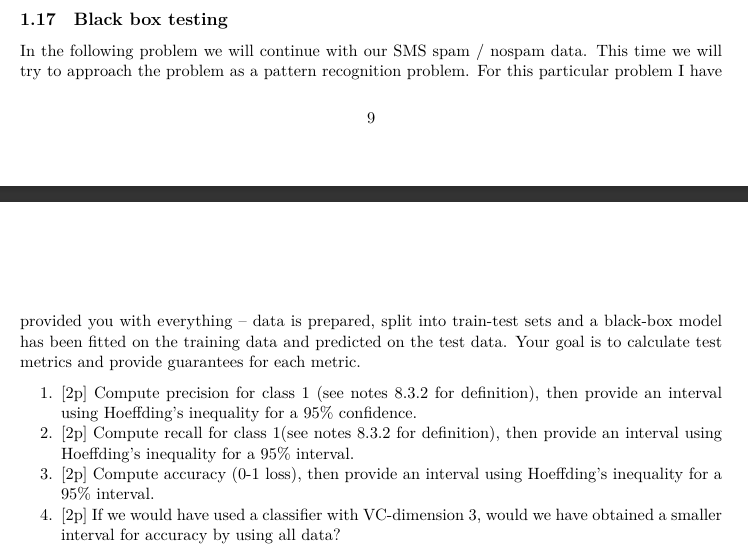

In [ ]:
# Block 1: Import data and prepare for analysis
import exam_extras
from exam_extras import load_sms_problem6

X_problem6, Y_problem6 = load_sms_problem6()

X_train_problem6, X_test_problem6, Y_train_problem6, Y_test_problem6 = exam_extras.train_test_split(
    X_problem6, Y_problem6
)
predictions_problem6 = exam_extras.knn_predictions(
    X_train_problem6, Y_train_problem6, X_test_problem6, k=4
)


In [ ]:
# Block 2: Compute precision for class 1
from sklearn.metrics import precision_score

problem6_precision = precision_score(Y_test_problem6, predictions_problem6, pos_label=1)


In [ ]:
# Block 3: Compute precision interval length using Hoeffding’s inequality
import numpy as np

n_test_samples = len(Y_test_problem6)
delta = 0.05  # For 95% confidence
problem6_precision_l = np.sqrt(np.log(2 / delta) / (2 * n_test_samples))

In [ ]:
# Block 4: Compute recall for class 1
from sklearn.metrics import recall_score

problem6_recall = recall_score(Y_test_problem6, predictions_problem6, pos_label=1)


In [ ]:
# Block 5: Compute recall interval length using Hoeffding’s inequality
problem6_recall_l = np.sqrt(np.log(2 / delta) / (2 * n_test_samples))


In [ ]:
# Block 6: Compute accuracy (0-1 loss)
from sklearn.metrics import accuracy_score

problem6_accuracy = accuracy_score(Y_test_problem6, predictions_problem6)


In [ ]:
# Block 7: Compute accuracy interval length using Hoeffding’s inequality
problem6_accuracy_l = np.sqrt(np.log(2 / delta) / (2 * n_test_samples))


In [ ]:
# Block 8: Compute VC dimension-based interval parameter and compare
VC_dimension = 3  # Given VC dimension of 3
problem6_VC_l = np.sqrt((VC_dimension * np.log(n_test_samples) + np.log(1 / delta)) / (2 * n_test_samples))

problem6_VC_smaller = problem6_VC_l < problem6_accuracy_l
